# Data preparation
**Dataset:** [Instagram Images - 1,211,625 posts](https://www.kaggle.com/datasets/shmalex/instagram-images)

**Prerequisite:** On Google Drive, add a shortcut of the shared directory 'DL project' to a desired location (I did to `/content/drive/My Drive/Colab Notebooks`).  
I downloaded the contents of `/r/r/` of the original dataset and uploaded under `/content/drive/My Drive/Colab Notebooks/DL project/data_plain/r/r`. Then I run the following cells. Make sure to do the same and also adjust `base` and `save_to` values as needed if you desire to process more images.

We apply the following operations, and for each operation (and sub-operation), there will be a new folder in the `save_to` path for the processed images:

#### 1. Borders: white, black
Given an image of size `width x height`, we identify the bigger dimension as `side` and add borders to the image so that the resultant picture has `side x side` dimensions. However, if `width=height`, we just add borders of width 70px on all sides.  
We use #fff and #000 color borders and this behavior can be customized using `border_colors`.

#### 2. Filters: inkwell, lofi, aden
The supported filters are listed in the [pilgram documentation](https://github.com/akiomik/pilgram). We only use `inkwell`, `lofi`, and `aden`. (`inkwell` is a kind of black and white filter.)

#### 3. Crop to:
The following `position`s are accepted:
- center
- left_half
- right_half
- upper_half
- lower_half
- upperleft_quarter
- upperright_quarter
- lowerleft_quarter
- lowerright_quarter

#### 4. Mirror:
Flips image horizontally (left to right)

#### 5. Rotate: 45°, 90°, 180°
Returns a rotated copy of this image, rotated the given number of degrees counter clockwise around its centre. We rotate by 45°, 90°, and 180° and this behavior can be customized using `angles`.


In [ ]:
!pip install pillow
!pip install pilgram

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 817.4/817.4 kB 4.9 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
from PIL import Image, ImageOps
import pilgram

# https://pillow.readthedocs.io/en/stable/reference/ImageOps.html#PIL.ImageOps.pad
# https://pillow.readthedocs.io/en/stable/reference/ImageOps.html#PIL.ImageOps.expand
def add_borders(img, fill_color):
  width, height = img.size
  if width == height:
    padding = 70
    return ImageOps.expand(img, border=padding, fill=fill_color)
  else:
    side = width if width>height else height
    return ImageOps.pad(img, size=(side, side), color=fill_color, centering=(0.5,0.5))

# https://github.com/akiomik/pilgram
def apply_filter(img, filter):
  filter = getattr(pilgram, filter)
  return filter(img)

# https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.Image.crop
def crop_to(img, position):
  width, height = img.size
  if position == 'center':
    (left, upper, right, lower) = (width/4, height/4, 3*width/4, 3*height/4)
  elif position == 'left_half':
    (left, upper, right, lower) = (0, 0, width/2, height)
  elif position == 'right_half':
    (left, upper, right, lower) = (width/2, 0, width, height)
  elif position == 'upper_half':
    (left, upper, right, lower) = (0, 0, width, height/2)
  elif position == 'lower_half':
    (left, upper, right, lower) = (0, height/2, width, height)
  elif position == 'upperleft_quarter':
    (left, upper, right, lower) = (0, 0, width/2, height/2)
  elif position == 'upperright_quarter':
    (left, upper, right, lower) = (width/2, 0, width, height/2)
  elif position == 'lowerleft_quarter':
    (left, upper, right, lower) = (0, height/2, width/2, height)
  elif position == 'lowerright_quarter':
    (left, upper, right, lower) = (width/2, height/2, width, height)
  else:
    raise Exception(f"Not a recognized position '{position}'")
    return None

  return img.crop((left, upper, right, lower))

# https://pillow.readthedocs.io/en/stable/reference/ImageOps.html#PIL.ImageOps.mirror
def mirror(img):
  return ImageOps.mirror(img)

# https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.Image.rotate
def rotate(img, angle):
  return img.rotate(angle)

In [ ]:
import os

def save_img(img, base, filename):
  if not os.path.exists(base):
    os.makedirs(base)
  img.save(f'{base}/{filename}')

def create_dataset(base, filename, save_to):
  image = Image.open(f'{base}/{filename}')
  width, height = image.size

  border_colors = ['#000', '#fff']
  for color in border_colors:
    bordered = add_borders(image, color)
    save_img(bordered, f'{save_to}/bordered/{color}', filename)

  filters = ['inkwell', 'lofi', 'aden']
  for filter in filters:
    filtered = apply_filter(image, filter)
    save_img(filtered, f'{save_to}/filtered/{filter}', filename)

  positions = ['center', 'left_half', 'right_half', 'upper_half', 'lower_half', 'upperleft_quarter', 'upperright_quarter', 'lowerleft_quarter', 'lowerright_quarter']
  for position in positions:
    cropped = crop_to(image, position)
    save_img(cropped, f'{save_to}/cropped/{position}', filename)

  mirrored = mirror(image)
  save_img(mirrored, f'{save_to}/mirrored', filename)

  angles = [45, 90, 180]
  for angle in angles:
    rotated = rotate(image, angle)
    save_img(rotated, f'{save_to}/rotated/{angle}', filename)

## remove comments to run and process data
# base = "/content/drive/My Drive/Colab Notebooks/DL project/data_plain/r/r"
# save_to = "/content/drive/My Drive/Colab Notebooks/DL project/data_prepared/r/r"
# os.chdir(base)
# for file in os.listdir():
#   create_dataset(base, file, save_to)

# CLIP embeddings
Fetching embeddings for 100 random images using [openai/clip-vit-base-patch16](https://huggingface.co/openai/clip-vit-base-patch16) model and calculating cosine similarity scores. Printing the median scores.

In [ ]:
!pip install transformers

In [ ]:
import torch
from transformers import CLIPProcessor, CLIPModel

device = "cuda" if torch.cuda.is_available() else "cpu"
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")

config.json:   0%|          | 0.00/4.10k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/599M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [ ]:
import torch
import numpy as np
from sys import stdout

def get_edited_folders():
  return ['bordered/#000', 'bordered/#fff', 'cropped/center', 'cropped/left_half', 'cropped/lower_half', 'cropped/lowerleft_quarter', 'cropped/lowerright_quarter', 'cropped/right_half', 'cropped/upper_half', 'cropped/upperleft_quarter', 'cropped/upperright_quarter', 'filtered/aden', 'filtered/inkwell', 'filtered/lofi', 'mirrored', 'rotated/45', 'rotated/90', 'rotated/180']

def get_edited_filepaths(original_filepath):
  filepaths = []
  original_basepath, original_filename = os.path.split(os.path.abspath(original_filepath))
  edited_basepath = original_basepath.replace('data_plain', 'data_prepared')
  edited_folders = get_edited_folders()
  for folder in edited_folders:
    filepaths.append(f'{edited_basepath}/{folder}/{original_filename}')
  return filepaths

def get_embedding(filepath):
  img = Image.open(filepath).convert('RGB')
  inputs = processor(images=img, return_tensors="pt").to(device)
  with torch.no_grad():
    embedding = model.get_image_features(**inputs)
    embedding = embedding.flatten()
  return embedding

similarity = torch.nn.CosineSimilarity(dim=0)

original_basepath = '/content/drive/My Drive/Colab Notebooks/DL project/data_plain/r/r'
# os.chdir(original_basepath)

# edited_folders = get_edited_folders()
# all_similarities = {key: [] for key in edited_folders}
# for index, file in enumerate(np.random.choice(os.listdir(), 100, replace=False)):
#   if file.endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):
#     try:
#       stdout.write(f"\rProcessing {index+1}/100: {os.path.split(os.path.abspath(file))[1]}...")
#       stdout.flush()

#       original_embedding = get_embedding(file)
#       edited_filepaths = get_edited_filepaths(file)
#       edited_embeddings = [get_embedding(edited_file) for edited_file in edited_filepaths]
#       for index, edited_folder in enumerate(edited_folders):
#         similarity_score = similarity(original_embedding, edited_embeddings[index])
#         all_similarities[edited_folder].append(similarity_score)
#     except Exception as e:
#       stdout.write(e)
#   else:
#     stdout.write(f"Skipping {os.path.split(os.path.abspath(file))[1]}...")

In [ ]:
# median_similarities = {key: np.median(all_similarities[key]) for key in edited_folders}

# median_similarities

{'bordered/#000': 0.9351896,
 'bordered/#fff': 0.9393552,
 'cropped/center': 0.8560287,
 'cropped/left_half': 0.83468646,
 'cropped/lower_half': 0.8126681,
 'cropped/lowerleft_quarter': 0.7813966,
 'cropped/lowerright_quarter': 0.7607939,
 'cropped/right_half': 0.81455845,
 'cropped/upper_half': 0.830137,
 'cropped/upperleft_quarter': 0.7839469,
 'cropped/upperright_quarter': 0.77876794,
 'filtered/aden': 0.97554183,
 'filtered/inkwell': 0.8930361,
 'filtered/lofi': 0.9560138,
 'mirrored': 0.98236513,
 'rotated/45': 0.90016365,
 'rotated/90': 0.8970428,
 'rotated/180': 0.82032096}

# 1st place solution from ISC21 Descriptor Track
Fetching embeddings for 20 random images using the [1st place solution from ISC21 Descriptor Track](https://github.com/lyakaap/ISC21-Descriptor-Track-1st) model. Then calculating cosine similarity scores and also the median scores.

Find the scores in the file: '/content/drive/My Drive/Colab Notebooks/DL project/data_prepared/isc21.csv'

Also calculated scores for the 3 images presented in the Progress Presentation. Find the scores in: '/content/drive/My Drive/Colab Notebooks/DL project/data_prepared/3images_isc21.csv'

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
import numpy as np
import pandas as pd
from pathlib import Path

def get_edited_folders():
  return ['bordered/#000', 'bordered/#fff', 'cropped/center', 'cropped/left_half', 'cropped/lower_half', 'cropped/lowerleft_quarter', 'cropped/lowerright_quarter', 'cropped/right_half', 'cropped/upper_half', 'cropped/upperleft_quarter', 'cropped/upperright_quarter', 'filtered/aden', 'filtered/inkwell', 'filtered/lofi', 'mirrored', 'rotated/45', 'rotated/90', 'rotated/180']

data = {}

original_basepath = '/content/drive/My Drive/Colab Notebooks/DL project/data_plain/r/r'
os.chdir(original_basepath)

original_files = np.random.choice(os.listdir(), 20, replace=False)
data["filename"] = original_files

edited_folders = get_edited_folders()
for folder in edited_folders:
  data[folder] = ["" for file in original_files]

data_file = '/content/drive/My Drive/Colab Notebooks/DL project/data_prepared/isc21.csv'
df = pd.DataFrame(data)
if not Path(data_file).is_file():
  df.to_csv(data_file, index=False)
else:
  print("File already exists! Not overwriting...")

In [ ]:
!pip install git+https://github.com/lyakaap/ISC21-Descriptor-Track-1st

  Cloning https://github.com/lyakaap/ISC21-Descriptor-Track-1st to /tmp/pip-req-build-w528us6w
  Running command git clone --filter=blob:none --quiet https://github.com/lyakaap/ISC21-Descriptor-Track-1st /tmp/pip-req-build-w528us6w
  Resolved https://github.com/lyakaap/ISC21-Descriptor-Track-1st to commit 228aad34ac5d5be77bf026dcda0a7b97d74da210
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.3 MB/s eta 0:00:00
  Created wheel for isc-feature-extractor: filename=isc_feature_extractor-1.0.1-py3-none-any.whl size=4279 sha256=51cf9db921e12ccb5111b3f5f4fca03e6b6aeecfe34e44baa3763d34f039fdaa
  Stored in directory: /tmp/pip-ephem-wheel-cache-iqapsgcs/wheels/5e/23/73/f6669a77dfa3934f7f5a6e50c69e0b79ff0f143c58fcaf476f
Successfully built isc-feature-extractor


In [ ]:
import torch
import numpy as np
import pandas as pd
from isc_feature_extractor import create_model
from pathlib import Path
from PIL import Image

def get_edited_folders():
  return ['bordered/#000', 'bordered/#fff', 'cropped/center', 'cropped/left_half', 'cropped/lower_half', 'cropped/lowerleft_quarter', 'cropped/lowerright_quarter', 'cropped/right_half', 'cropped/upper_half', 'cropped/upperleft_quarter', 'cropped/upperright_quarter', 'filtered/aden', 'filtered/inkwell', 'filtered/lofi', 'mirrored', 'rotated/45', 'rotated/90', 'rotated/180']

def get_next_file(df):
  files = df['filename']
  folders = get_edited_folders()

  for index, file in enumerate(files):
    for folder in folders:
      if pd.isnull(df[folder].iloc[index]):
        return file, folder
  print("No more files left")
  return None, None

def get_embedding(file, folder):
  if folder == 'original':
    filepath = f'{original_basepath}/{file}'
  else:
    filepath = f'{edited_basepath}/{folder}/{file}'
  image = Image.open(filepath)
  image_em = model(preprocessor(image).unsqueeze(0))
  return image_em

def get_sim(em1, em2):
  score = sim(em1[0], em2[0])
  return float(score)

# recommended_weight_name = 'isc_ft_v107'
# model, preprocessor = create_model(weight_name=recommended_weight_name, device='cpu')

# sim = torch.nn.CosineSimilarity(dim=0)

# original_basepath = '/content/drive/My Drive/Colab Notebooks/DL project/data_plain/r/r'
# edited_basepath = original_basepath.replace('data_plain', 'data_prepared')

# em_path = '/content/drive/My Drive/Colab Notebooks/DL project/data_prepared/embeddings'
# data_file = '/content/drive/My Drive/Colab Notebooks/DL project/data_prepared/isc21.csv'
# df = pd.read_csv(data_file)

# while True:
#   file, folder = get_next_file(df)
#   if file and folder:
#     em_file = f'{em_path}/{file.split(".")[0]}.pt'
#     if not Path(em_file).is_file():
#       image_em = get_embedding(file, 'original')
#       torch.save(image_em, em_file)
#     else:
#       image_em = torch.load(em_file)
#     edited_em = get_embedding(file, folder)
#     df.loc[df['filename'] == file, folder] = get_sim(image_em, edited_em)
#     df.to_csv(data_file, index=False)
#   else:
#     break

Downloading: "https://github.com/lyakaap/ISC21-Descriptor-Track-1st/releases/download/v1.0.1/isc_ft_v107.pth.tar" to /root/.cache/torch/hub/isc_ft_v107.pth.tar
100%|██████████| 401M/401M [00:05<00:00, 73.9MB/s]


No more files left


In [ ]:
data_file = '/content/drive/My Drive/Colab Notebooks/DL project/data_prepared/isc21.csv'
df = pd.read_csv(data_file)

folders = get_edited_folders()

all_similarities = {}
for index, file in enumerate(df['filename']):
  for folder in folders:
    if folder in all_similarities:
      all_similarities[folder].append(df[folder].iloc[index])
    else:
      all_similarities[folder] = [df[folder].iloc[index]]

median_similarities = {key: np.median(all_similarities[key]) for key in folders}
median_similarities

{'bordered/#000': 0.9732288122177124,
 'bordered/#fff': 0.966046929359436,
 'cropped/center': 0.7610231935977936,
 'cropped/left_half': 0.768709272146225,
 'cropped/lower_half': 0.6433299481868744,
 'cropped/lowerleft_quarter': 0.5607280731201172,
 'cropped/lowerright_quarter': 0.4615652859210968,
 'cropped/right_half': 0.7375589609146118,
 'cropped/upper_half': 0.6609036922454834,
 'cropped/upperleft_quarter': 0.5427561700344086,
 'cropped/upperright_quarter': 0.5233480632305145,
 'filtered/aden': 0.9930803179740906,
 'filtered/inkwell': 0.9637176990509033,
 'filtered/lofi': 0.976711630821228,
 'mirrored': 0.9738823175430298,
 'rotated/45': 0.8294101655483246,
 'rotated/90': 0.8391557335853577,
 'rotated/180': 0.8980903923511505}

# ResNet50
Fetching embeddings for 100 random images using [ResNet50](https://huggingface.co/docs/transformers/main/en/model_doc/resnet) model and calculating cosine similarity scores. Printing the median scores.

The high values are not an indication of the model performing better than the other models. When you observe how the scores are similar for even images that have no similarity whatsoever, it is obvious that the embeddings for these models are not great at capturing aspects about the image contents as well as the previous two.



In [ ]:
from transformers import AutoImageProcessor, ResNetForImageClassification
from PIL import Image
import numpy as np
import os
import torch

def get_edited_folders():
  return ['bordered/#000', 'bordered/#fff', 'cropped/center', 'cropped/left_half', 'cropped/lower_half', 'cropped/lowerleft_quarter', 'cropped/lowerright_quarter', 'cropped/right_half', 'cropped/upper_half', 'cropped/upperleft_quarter', 'cropped/upperright_quarter', 'filtered/aden', 'filtered/inkwell', 'filtered/lofi', 'mirrored', 'rotated/45', 'rotated/90', 'rotated/180']

def get_em(filepath):
  image = Image.open(filepath)
  inputs = image_processor(image, return_tensors="pt")
  with torch.no_grad():
      logits = model(**inputs).logits
  return logits

image_processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")

original_basepath = '/content/drive/My Drive/Colab Notebooks/DL project/data_plain/r/r'
edited_basepath = original_basepath.replace('data_plain', 'data_prepared')
os.chdir(original_basepath)

all_ems = []
file_ems = []
folders = get_edited_folders()
for file in np.random.choice(os.listdir(), 100, replace=False):
  edited_ems = []
  filepath = f'{original_basepath}/{file}'
  file_ems.append(get_em(filepath))
  for folder in folders:
    filepath = f'{edited_basepath}/{folder}/{file}'
    em = get_em(filepath)
    edited_ems.append(em)
  all_ems.append(edited_ems)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [ ]:
import pandas as pd

all_sims = []
sim = torch.nn.CosineSimilarity(dim=0)
for index, em in enumerate(file_ems):
  folder_ems = all_ems[index]
  sims = [sim(em[0], folder_em[0]) for folder_em in folder_ems]
  all_sims.append(sims)

df = pd.DataFrame.from_records(all_sims)
for index, folder in enumerate(folders):
  folder_ems = list(df.iloc[:,index])
  median = np.median(folder_ems)
  print(f'{folder}: {median}')

bordered/#000: 0.9969781637191772
bordered/#fff: 0.9970252513885498
cropped/center: 0.9917683601379395
cropped/left_half: 0.9913122653961182
cropped/lower_half: 0.9904935359954834
cropped/lowerleft_quarter: 0.9893906116485596
cropped/lowerright_quarter: 0.9885022640228271
cropped/right_half: 0.9913276433944702
cropped/upper_half: 0.9905592799186707
cropped/upperleft_quarter: 0.9889092445373535
cropped/upperright_quarter: 0.989626407623291
filtered/aden: 0.9987200498580933
filtered/inkwell: 0.9943838119506836
filtered/lofi: 0.9987360239028931
mirrored: 0.998655378818512
rotated/45: 0.9923090934753418
rotated/90: 0.9897346496582031
rotated/180: 0.9913981556892395


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


tensor(0.9820)


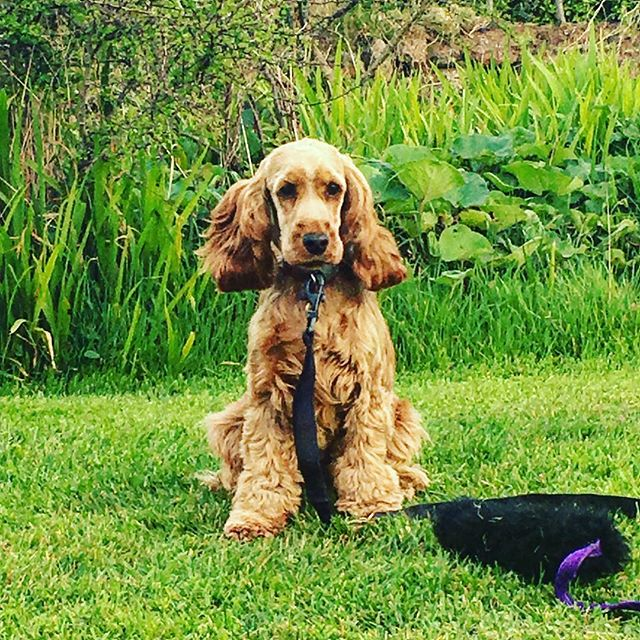

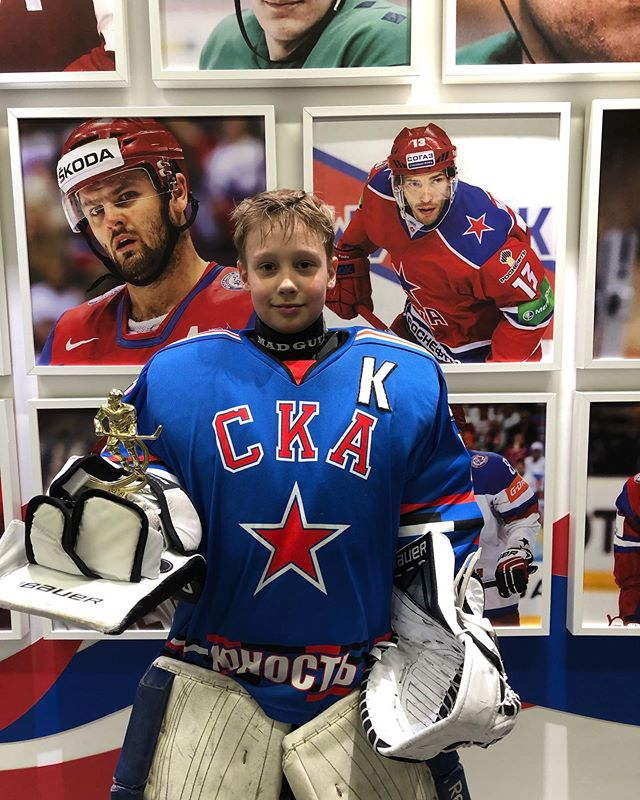

In [ ]:
# ResNet50 is not capable of capturing aspects about the image contents
from transformers import AutoImageProcessor, ResNetForImageClassification
from PIL import Image
import numpy as np
import torch

original_basepath = '/content/drive/My Drive/Colab Notebooks/DL project/data_plain/r/r'
file1 = 'BwjvPEAgrRr.jpg'
file2 = 'BxNDSVPAXRr.jpg'

image_processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")

def get_em(filepath):
  image = Image.open(filepath)
  inputs = image_processor(image, return_tensors="pt")
  with torch.no_grad():
      logits = model(**inputs).logits
  return logits

sim = torch.nn.CosineSimilarity(dim=0)
em1 = get_em(f'{original_basepath}/{file1}')
em2 = get_em(f'{original_basepath}/{file2}')
print(sim(em1[0], em2[0]))

from IPython.display import Image, display
display(Image(f'{original_basepath}/{file1}'))
display(Image(f'{original_basepath}/{file2}'))

# Finding similarity for images that are look-alikes


In [ ]:
!pip install transformers

In [ ]:
import torch
from transformers import CLIPProcessor, CLIPModel

device = "cuda" if torch.cuda.is_available() else "cpu"
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")

In [ ]:
from PIL import Image

def get_embedding(filepath):
  img = Image.open(filepath).convert('RGB')
  inputs = processor(images=img, return_tensors="pt").to(device)
  with torch.no_grad():
    embedding = model.get_image_features(**inputs)
    embedding = embedding.flatten()
  return embedding

import string
chars = list(string.ascii_lowercase)[:12]
file_groups = [[f'{char}1.jpg', f'{char}2.jpg'] for char in chars]
files = [file for file_group in file_groups for file in file_group]

basepath = '/content/drive/My Drive/Colab Notebooks/DL project/data_lookalikes'
embeddings = {}
for file in files:
  filepath = f'{basepath}/{file}'
  embeddings[file] = get_embedding(filepath)

In [ ]:
similarity = torch.nn.CosineSimilarity(dim=0)

all_similarities = []
for file_group in file_groups:
  all_similarities.append(similarity(embeddings[file_group[0]], embeddings[file_group[1]]).item())
all_similarities

[0.9420349597930908,
 0.9465662240982056,
 0.9336879849433899,
 0.9340845346450806,
 0.9157726168632507,
 0.8227208256721497,
 0.960853099822998,
 0.9562134146690369,
 0.9403919577598572,
 0.9079873561859131,
 0.8895834684371948,
 0.8141864538192749]